In [113]:
# Import packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('avocado.csv')


In [78]:
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [79]:
data.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

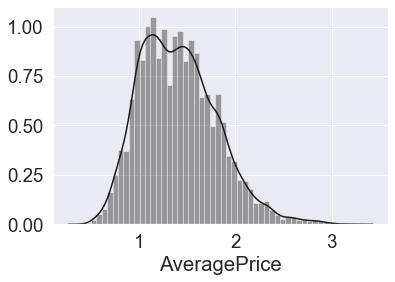

In [56]:
sns.distplot(data["AveragePrice"], color = 'k')

<function matplotlib.pyplot.show(*args, **kw)>

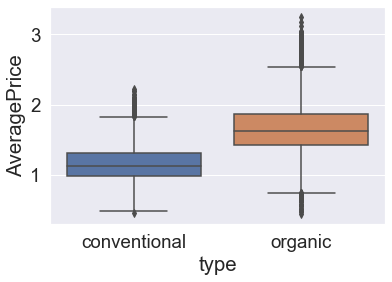

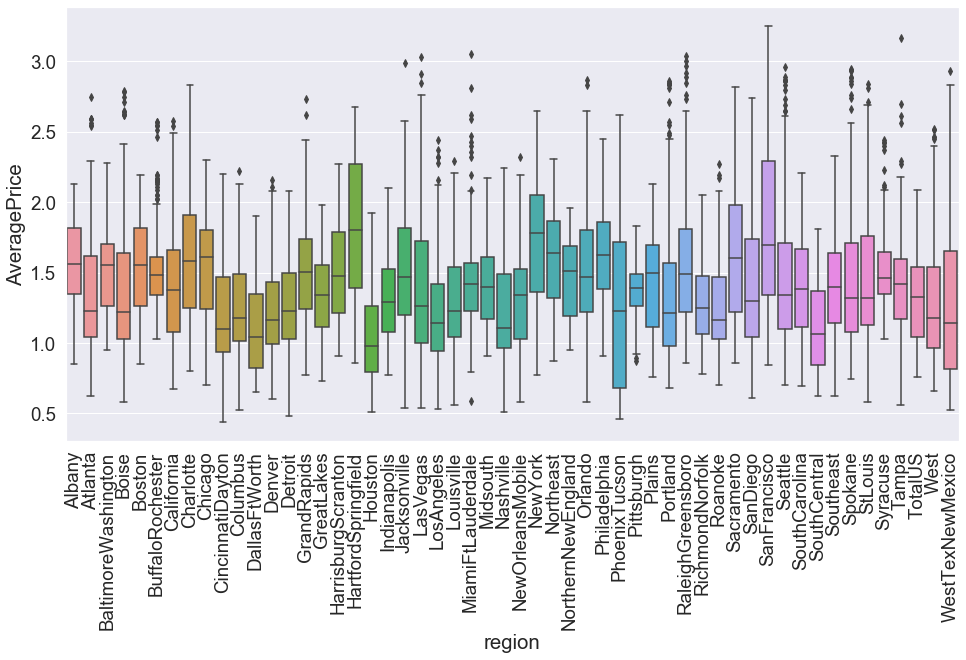

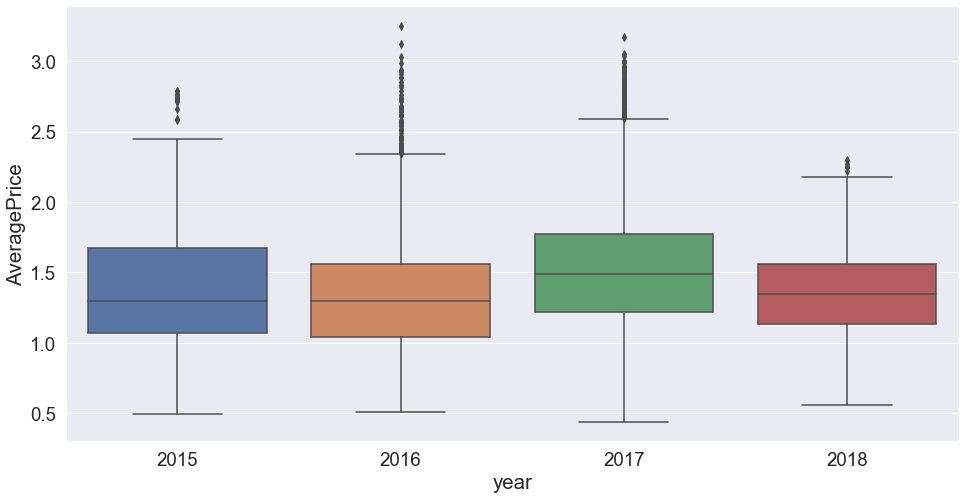

In [57]:
sns.boxplot(y='AveragePrice',x='type',data=data)
f,ax = plt.subplots(figsize=(16,8))
sns.boxplot(y='AveragePrice',x='region',data=data)
plt.xticks(rotation='vertical')
f,ax = plt.subplots(figsize=(16,8))
sns.boxplot(y='AveragePrice',x='year',data=data)
plt.show

Organic avocados are more expensive, which is expected since cultivating them is a more intensive process.  The region seems to have some effect on the price of the avocado as the price varies per region.  Each year the price of avocados is about the same, besides 2017 where there was a notable shortage of avocados.

In [126]:
# Encoding type as 0 or 1
label = LabelEncoder()
dicts = {}

label.fit(data.type.drop_duplicates()) 
dicts['type'] = list(label.classes_)
data.type = label.transform(data.type) 

                             ARIMA Model Results                              
Dep. Variable:        D2.AveragePrice   No. Observations:                18247
Model:                ARIMA(10, 2, 1)   Log Likelihood                5743.389
Method:                       css-mle   S.D. of innovations              0.177
Date:                Tue, 19 Nov 2019   AIC                         -11442.777
Time:                        20:33:19   BIC                         -11270.919
Sample:                             2   HQIC                        -11386.300
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0003      0.000      1.942      0.052   -2.87e-06       0.001
Total Volume           -7.148e-07        nan        nan        nan         nan         nan
4046

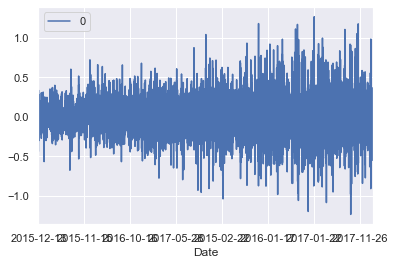

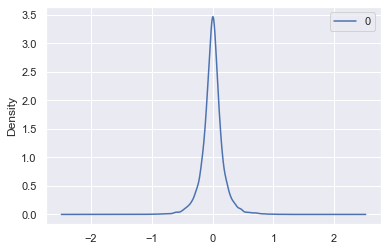

                  0
count  18247.000000
mean       0.000240
std        0.176654
min       -1.237833
25%       -0.082653
50%        0.001141
75%        0.081089
max        1.266470


In [144]:
#ARIMA Price Prediction

data2 = data.set_index(data.Date)
endog = data2.AveragePrice
exog = data.drop(['region','Unnamed: 0','Date','AveragePrice','year'],axis=1)
exog = exog.set_index(data.Date)
model = ARIMA(endog=endog, order=(10,2,1), exog=exog)
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

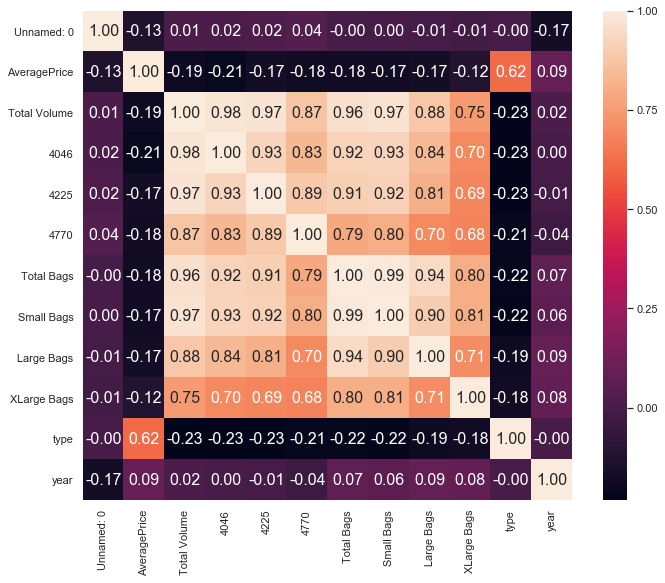

In [137]:
# Correlation Heatmap
corr = data.corr()
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(11, 9))
hm = sns.heatmap(corr,cbar = True, annot = True,square = True, fmt = '.2f', annot_kws = {'size':16})

In [100]:
x = data.drop(['type','region','Date'], axis = 1) #dropping type and categorical variables
y = data.type
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 0,test_size=0.3)
print(x_train.shape,x_test.shape)
x.head()

(12774, 11) (5475, 11)


,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
0,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015
1,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015
2,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015
3,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015
4,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015


In [101]:
logreg =  LogisticRegression(penalty='l1', tol=0.0001).fit(x_train,y_train)
logpredict = logreg.predict(x_test)
c = confusion_matrix(logpredict,y_test)
print("Predicted",c[0][0],"conventional correctly and",c[0][1],"incorrectly")
print("Predicted",c[1][1],"organic correctly and",c[1][0],"incorrectly")
print("Overall Accuracy Rate:",(c[0][0]+c[1][1])/(c[0][0]+c[1][1]+c[0][1]+c[1][0]))
print("Conventional Prediction Accuracy:",c[0][0]/(c[0][0]+c[0][1]))
print("Organic Prediction Accuracy:",c[1][1]/(c[1][1]+c[1][0]))

Predicted 2520 conventional correctly and 80 incorrectly
Predicted 2669 organic correctly and 206 incorrectly
Overall Accuracy Rate: 0.9477625570776256
Conventional Prediction Accuracy: 0.9692307692307692
Organic Prediction Accuracy: 0.9283478260869565


In [111]:
rf =  RandomForestClassifier(n_estimators = 100, random_state = 0, max_features = 2)
rf.fit(x_train,y_train)
rfpredict = rf.predict(x_test)
c = confusion_matrix(rfpredict,y_test)
print("Predicted",c[0][0],"conventional correctly and",c[0][1],"incorrectly")
print("Predicted",c[1][1],"organic correctly and",c[1][0],"incorrectly")
print("Overall Accuracy Rate:",(c[0][0]+c[1][1])/(c[0][0]+c[1][1]+c[0][1]+c[1][0]))
print("Conventional Prediction Accuracy:",c[0][0]/(c[0][0]+c[0][1]))
print("Organic Prediction Accuracy:",c[1][1]/(c[1][1]+c[1][0]))

Predicted 2714 conventional correctly and 21 incorrectly
Predicted 2728 organic correctly and 12 incorrectly
Overall Accuracy Rate: 0.993972602739726
Conventional Prediction Accuracy: 0.9923217550274223
Organic Prediction Accuracy: 0.9956204379562044


In [109]:
kfold = 7 
knn = KNeighborsClassifier(n_neighbors = 200) 
knn.fit(x_train, y_train)
knnpredict = knn.predict(x_test)
c = confusion_matrix(knnpredict,y_test)
print("Predicted",c[0][0],"conventional correctly and",c[0][1],"incorrectly")
print("Predicted",c[1][1],"organic correctly and",c[1][0],"incorrectly")
print("Overall Accuracy Rate:",(c[0][0]+c[1][1])/(c[0][0]+c[1][1]+c[0][1]+c[1][0]))
print("Conventional Prediction Accuracy:",c[0][0]/(c[0][0]+c[0][1]))
print("Organic Prediction Accuracy:",c[1][1]/(c[1][1]+c[1][0]))


Predicted 2647 conventional correctly and 249 incorrectly
Predicted 2500 organic correctly and 79 incorrectly
Overall Accuracy Rate: 0.9400913242009132
Conventional Prediction Accuracy: 0.9140193370165746
Organic Prediction Accuracy: 0.9693679720822024
